# 1. Imports

In [1]:
#Imports - general
import random
random.seed(15)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from math import sqrt
from sklearn.metrics import f1_score, roc_curve, auc, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline

#Imports - RDKit
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import *

#Imports - additional
from os import listdir #for getting a list of files in a dir to process checkpoints
import time # for real-time timing the progress of the network

# Some global variables

In [2]:
batch_number = 0
#Get the list of filenames in data/targets/
#ordered by the size of class, descending:
with open("receptors_desc.txt", "r") as f:
    receptors = [l.strip().split() for l in f.readlines()]
print(len(receptors))
receptors[:5]

73


[['DRD2.ism', '6229'],
 ['HTR1A.ism', '5592'],
 ['SLC6A4.ism', '5414'],
 ['OPRM1.ism', '5263'],
 ['ADORA1.ism', '4136']]

---

# 2. Functions

## Preparing the dataset

#### Reading smiles of molecules from .ism files

In [3]:
def read_ism(file_name):
    ''' Parse an .ism file, returning a list of smiles of molecules '''
    mol_list = []
    with open(file_name, 'r') as f:
        frl = f.readlines()
    for line in frl:
        line = line.split('\t')
        smile = line[0]
        mol_list.append(smile)
    return mol_list

#### Creating molecule representations

In [4]:
def get_class_vectors(mol_matrix, rType = 'fingerprint', f_size=2048):
    ''' For each molecule in the array (list of lists):
        create its representation for training (ingerprint/descriptor/mixed)
        and a binary vector showing which classes it belongs to.
        Fingerprint will be of size = f_size.
    '''
    cv_dict = {}
    for i,l in enumerate(mol_matrix):
        for smile in l:
            if smile not in cv_dict:
                
                mol = MolFromSmiles(smile)
                if rType == 'fingerprint':
                    rep = fingerprint(mol, f_size)
                elif rType == 'descriptor':
                    rep = descriptor(mol)
                else:
                    rep = descriptor(mol) + list(fingerprint(mol, f_size))
                
                labels = [0]*len(mol_matrix)
                cv_dict[smile] = [rep, labels]
            cv_dict[smile][1][i] = 1
    # Normalize descriptors
    if rType != 'fingerprint':
        matrix_to_norm = []
        for vals in cv_dict.values():
            matrix_to_norm.append(vals[0][:37]) #there are 37 descriptors
        matrix_to_norm = np.array(matrix_to_norm)
        v_min = matrix_to_norm.min(axis=0)
        v_max = matrix_to_norm.max(axis=0) - v_min
        for key in cv_dict.keys():
            for i in range(37):
                normed_val = (cv_dict[key][0][i] - v_min[i]) / v_max[i]
                cv_dict[key][0][i] = normed_val
    return cv_dict

def fingerprint(mol, f_size=2048):
    return GetMorganFingerprintAsBitVect(mol,2,f_size)

def descriptor(mol):
    functions = [CalcChi0n,
            CalcChi0v,
            CalcChi1n,
            CalcChi1v,
            CalcChi2n,
            CalcChi2v,
            CalcChi3n,
            CalcChi3v,
            CalcChi4n,
            CalcChi4v,
            CalcExactMolWt,
            CalcFractionCSP3,
            CalcHallKierAlpha,
            CalcKappa1,
            CalcKappa2,
            CalcKappa3,
            CalcLabuteASA,
            CalcNumAliphaticCarbocycles,
            CalcNumAliphaticHeterocycles,
            CalcNumAliphaticRings,
            CalcNumAmideBonds,
            CalcNumAromaticCarbocycles,
            CalcNumAromaticHeterocycles,
            CalcNumAromaticRings,
            CalcNumBridgeheadAtoms,
            CalcNumHBA,
            CalcNumHBD,
            CalcNumHeteroatoms,
            CalcNumHeterocycles,
            CalcNumLipinskiHBA,
            CalcNumLipinskiHBD,
            CalcNumRings,
            CalcNumSaturatedCarbocycles,
            CalcNumSaturatedHeterocycles,
            CalcNumSaturatedRings,
            CalcNumSpiroAtoms,
            CalcTPSA]
        
    descriptors = []
    for function in functions:
        descriptors.append(function(mol))
    return descriptors

#### Creating training and validation sets

In [5]:
def prepare_sets(mol_matrix, val_prc=0.25, rType='fingerprint', f_size=2048):
    ''' Create training and validation sets with labels from an array of smiles
        rType - type of representation - fingerprint/descriptor/mixed
        f_size - size of the fingerprint if rType is fingerprint or mixed '''
    # Create a representation and a class vector for each molecule
    molecules = get_class_vectors(mol_matrix,rType,f_size)

    # Split the data into training and validation sets
    mts=[[],[]]
    for val in molecules.values():
        mts[0].append(val[0]) # [fingerprint]
        mts[1].append(val[1]) # [label]

    molecules_split = train_test_split(mts[0], mts[1], test_size=val_prc, random_state=15, stratify=mts[1])

    # Validation set:
    #     a list of representations (mols) and
    #     a list of corresponding class vectors (labels)
    val_mols = np.array(molecules_split[1])
    val_labels = np.array(molecules_split[3])
    # Training set:
    train_set = [[],[]]
    train_set[0] = np.array(molecules_split[0])
    train_set[1] = np.array(molecules_split[2])
    
    return train_set, val_mols, val_labels

## Neuron layers

In [6]:
def neuron_layer(isize, hsize, prev_layer):
    ''' Create a single neuron layer - weight, bias, placeholder '''
    # weights and biases
    w = tf.Variable(tf.random_normal((isize, hsize), stddev=1/sqrt(isize)))
    b = tf.Variable(tf.random_normal((hsize,), stddev=0.1))
    # neuron
    h = tf.nn.relu(tf.matmul(prev_layer, w) + b)
    return w,b,h

def setup_layers(layers, osize, isize=2048):
    ''' Create placeholders, weights and biases for all requested layers '''
    x = tf.placeholder(tf.float32, shape=[None,isize])
    active_layers = {'x':x,'w':[],'b':[],'h':[]}
    
    for i in range(len(layers)):
        if i == 0:
            w,b,h = neuron_layer(isize, layers[0], x)
        else:
            w,b,h = neuron_layer(layers[i-1], layers[i], prev_h)
        active_layers['w'].append(w)
        active_layers['b'].append(b)
        active_layers['h'].append(h)
        prev_h = h
    
    # Output Layer
    wo = tf.Variable(tf.random_normal((layers[-1], osize), stddev=1/sqrt(layers[-1])))
    bo = tf.Variable(tf.random_normal((osize,), stddev=0.1))
    a = tf.matmul(h, wo) + bo #h is the one last initialized in the loop > of the last layer
    
    # Placeholder for targets
    t = tf.placeholder(tf.float32, shape=[None, osize])
    
    active_layers['out'] = [wo,bo,a,t]
    return active_layers

## Training functions

In [7]:
def next_batch(data, size): #data = [[fingerprints], [labels]]
    ''' Extract the next batch from a dataset.
        If dataset size is not dividable by batch size with reminder 0,
       the last full batch and the remaining incomplete batch will be merged 
       to incorporate all data.'''
    global batch_number
    if batch_number == len(data[0])//size-1:
        #the last batch may be larger to incorporate all data
        # -1 because the first batch number is 0
        start = batch_number*size
        batch_number = 0
        return data[0][start:], data[1][start:]
    start = batch_number*size
    batch_number += 1
    return data[0][start:start+size], data[1][start:start+size]

def shuffle_data(data):
    '''Used to shuffle the training set after an epoch'''
    indices = list(range(len(data[0])))
    random.shuffle(indices)
    new_data = [data[0][indices], data[1][indices]]
    return new_data

def timer(start,end):
    ''' For timing the training of the network '''
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds))

def tf_fractions(a1, a2):
    ''' Calculate true/false positives/negatives in a2 based on a1
        for each class seperately. '''
    num_class = len(a1[0]) #number of classes
    tp = np.array([0] * num_class)
    fn = np.array([0] * num_class)
    tn = np.array([0] * num_class)
    fp = np.array([0] * num_class)
    for i in range(num_class):
        for j in range(len(a1)):
            if a2[j][i] == a1[j][i]:
                if a1[j][i] == 1:
                    tp[i] += 1
                else:
                    tn[i] += 1
            else:
                if a1[j][i] == 1:
                    fn[i] += 1
                else:
                    fp[i] += 1
    return [tp,fn,tn,fp]

In [8]:
def train_network(data, batch_size, epochs, verbose=True, save=True):
    ''' This function trains the network, returning the rate of training and validation accuracy,
         the F1 measure and true/false fractions.'''
    # Variables:
    global start, train, batch_number
    iterations = len(data[0]) // batch_size * epochs
    if verbose: print(iterations, ' iterations')
    tr_rate = []
    val_rate = []
    f1 = [[],[],[]]
    tf_frac = []
    batch_number = 0
    save_step=0
    # Training:
    with tf.Session() as session:
        session.run(tf.initialize_all_variables())

        if save:
            saver.save(session, "tmp/checkpoint", global_step=save_step)
        
        # Train the network
        for i in range(iterations):
            if i != 0 and batch_number == 0:
                data = shuffle_data(data)
            
            mols, labels = next_batch(data, batch_size)
            
            session.run(train, feed_dict={x: mols, t: labels})
            
            # Display progress and make a checkpoint
            if i == 0 or (i+1)%(iterations//10) == 0:
                if save:
                    save_step += 1
                    saver.save(session, "tmp/checkpoint", global_step = save_step)
                if verbose:
                    progress = int((i+1)/(iterations//10))*10
                    now = timer(start,time.time())
                    print("%3i" % progress + '%, ' + str(now))                
            
            # Validate predictions
            if i % 200 == 0 or i == iterations-1:
                
                tr_target = labels
                tr_predictions = session.run(predict, feed_dict={x: mols, t: labels})
                tr_rate.append((tr_target == tr_predictions).all(axis=1).mean())

                val_predictions = session.run(predict, feed_dict={x: val_mols, t: val_labels})
                val_rate.append((val_labels == val_predictions).all(axis=1).mean())
                
                f1[0].append(f1_score(val_labels, val_predictions, average='micro'))
                f1[1].append(f1_score(val_labels, val_predictions, average='macro'))
                f1[2].append(f1_score(val_labels, val_predictions, average='weighted'))
                
        tf_frac = tf_fractions(val_labels,val_predictions)
        # Final checkpoint
        if save:
            saver.save(session, "tmp/checkpoint", global_step=save_step+1)
    return tr_rate, val_rate, f1, tf_frac

## Functions to draw and save plots

In [9]:
def filename_gen(plot_type='', path=''):
    ''' Generate filename for a plot. '''
    if plot_type != '':
        plot_type += '_'
    filename = plot_type
    layers_str = "{}'{}".format(len(layers),max(layers))
    filename += "{}_{}_{}_{:>6}_{}_{}_{:.4}_{}".format(
                num_class, f_size, layers_str, learning_rate, batch_size, epochs, max(val_rate), rType)
    filename = filename.replace(".","'")
    filename = filename.replace(" ","_")
    filename = path + filename + ".pdf"
    return filename

def save_accuracy_plot(tr_rate, save=True, path="plots/"):
    ''' Draws and saves a plot which displays changes of accuracy 
        during training for training and validation sets. '''
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    x = [i*200 for i in range(len(tr_rate))]
    ax.plot(x,tr_rate, label='trening')
    ax.plot(x,val_rate, label='walidacja')
    ax.legend(loc=5)
    ax.set_ylabel('Dokładność')
    ax.set_xlabel('Krok')
    plt.ylim([0,1])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    plt.title(title);
    
    if save:
        filename = filename_gen('',path)
        plt.savefig(filename);

def save_f1_plot(f1, save=True, path="plots/"):
    ''' Draws and saves a plot which displays changes of F1-score
        during training for the validation set.
        F1 calculated and drawn in three types of averaging. '''
    plt.close()
    fig = plt.figure()
    x = [i*200 for i in range(len(f1[0]))]
    ax = fig.add_subplot(111)
    
    ax.plot(x,f1[0], label='F1 micro')
    ax.plot(x,f1[1], label='F1 macro')
    ax.plot(x,f1[2], label='F1 ważone')
    ax.legend(loc=7)
    ax.set_ylabel('F1')
    ax.set_xlabel('Krok')
    plt.ylim([0,1])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    plt.title(title);
    
    if save:
        filename = filename_gen('f1',path)
        plt.savefig(filename);

def save_tf_fractions_plot(tff, save=True, path='plots/'):
    ''' Draws and saves a histogram of true/false positive/negative fractions:
        True Positive rate, False Positive Rate, False Negative Rate and
        False Discovery Rate.
        True Negative Rate not included due to having values indistinguishably
        close to 100%; however, TNR = 100% - FPR, and the FPR histogram is more
        visually clear. '''
    plt.close()
    fig = plt.figure()
    subplots = [fig.add_subplot(221), fig.add_subplot(222),
                fig.add_subplot(223), fig.add_subplot(224)]
    titles = ['Odsetek prawdziwie pozytywnych', 'Odsetek fałszywie pozytywnych',
              'Odsetek fałszywie negatywnych', 'Odsetek fałszywych odkryć']
    rate_values = [tff[0]/(tff[0]+tff[1]), tff[3]/(tff[2]+tff[3]),
                   tff[1]/(tff[0]+tff[1]), tff[3]/(tff[0]+tff[3])]
    xlabel = 'Cele terapeutyczne'
    xrange = range(1,len(tff[0])+1)
    
    for i, ax in enumerate(subplots):
        ax.bar(xrange, rate_values[i])
        ax.set_title(titles[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_xlim([0,num_class+2])
        vals = ax.get_yticks()
        if i == 1: #false positive rate is very small
            ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
        else:
            ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    plt.tight_layout()
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    fig.suptitle(title)
    fig.subplots_adjust(top=0.85)
    
    if save:
        filename = filename_gen('tff',path)
        plt.savefig(filename)

---

# 3. Script

### Prepare data

In [10]:
num_class = 73 #first n most numerous classes - 2<=n<=73
ism_path = 'data/targets/'   #path to .ism files which represent classes and contain molecules
mol_matrix = []
for line in receptors[:num_class]:
    name = line[0]
    mol_list = read_ism(ism_path + name)
    mol_matrix.append(mol_list)
mol_matrix[0][:3]

['CN1CCN(CC1)C2=Cc3ccccc3C(=C(C)C)c4ccccc24',
 'CN1CCN(CC1)C2=Nc3cc(Cl)ccc3Nc4ccccc24',
 'CN1CCC(CC1)C2=Cc3cc(Cl)ccc3Cc4ccccc24']

### Type of representation:

In [11]:
rType = 'fingerprint'
f_size = 4096        #size of fingerprint, if rType = 'fingerprint' or 'mixed'
%time train_set,val_mols,val_labels = prepare_sets(mol_matrix, 0.2, rType, f_size)

CPU times: user 7min 51s, sys: 452 ms, total: 7min 52s
Wall time: 7min 51s


###  User-defined network variables:

In [13]:
layers = [800,800]
learning_rate = 0.001
batch_size = 50
epochs = 10

### Create and train the network

In [14]:
tf.reset_default_graph()
tf.set_random_seed(15)
random.seed(15)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
start = time.time()

#Automatic network variables.
isize = len(val_mols[0])
osize = num_class
'''
isize - size of the input layer, equal to the size 
        of the data representation (fingerprint/descriptor)
osize - size of the output layer, equal to the number of classes.
'''

# Neuron layers
active_layers = setup_layers(layers, osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets

saver = tf.train.Saver(max_to_keep=12)

# Objective
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(a, t))
train = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Prediction
y = tf.nn.sigmoid(a)
predict = tf.round(y)

# Train the network
tr_rate, val_rate, f1, tf_frac = train_network(train_set, batch_size, epochs)
full_time = timer(start,time.time())
full_time

2017-10-20 14:00:53
13270  iterations
  0%, 00:00:02


/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 10%, 00:00:15
 20%, 00:00:32
 30%, 00:00:50
 40%, 00:01:05
 50%, 00:01:18
 60%, 00:01:32
 70%, 00:01:46
 80%, 00:02:00
 90%, 00:02:13
100%, 00:02:28


'00:02:32'

# 4. Plots for evaluating predictions, and saving results.

### Accuracy - training and validation rates

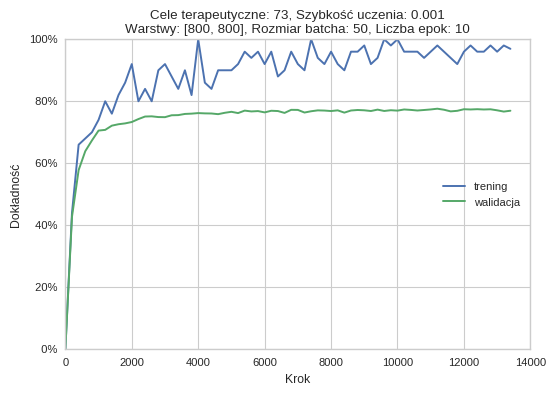

In [15]:
save_accuracy_plot(tr_rate, save=False, path='plots/')

### F1 score

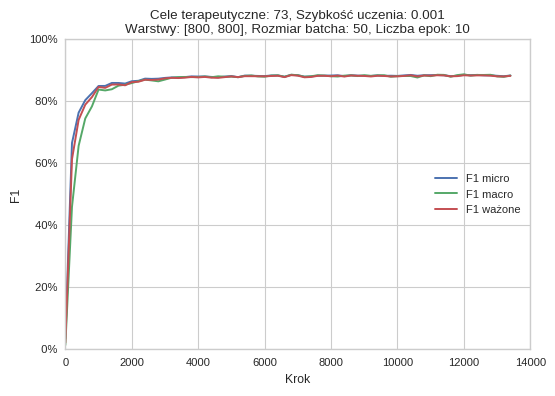

In [16]:
save_f1_plot(f1, save=False, path='plots/')

### True/false-positive/negative-related histograms

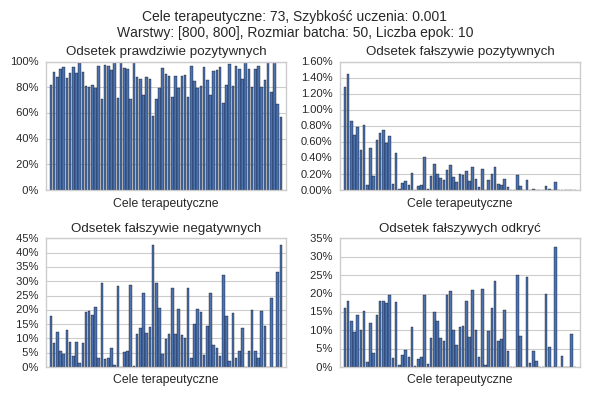

In [17]:
save_tf_fractions_plot(tf_frac, save=False, path='plots/')

### Saving results to file

In [ ]:
# Create a new file
with open('plots/desc/desc.csv','w') as f:
    f.write('Type of Representation,Number of classes,Fingerprint size,Hidden Layers,Learning Rate,Batch Size,Number of Epochs, Max. Validation Rate\n')

In [ ]:
def save_res_to_file(rType,num_class,f_size,layers,learning_rate,batch_size,epochs,max_val):
    with open('plots/desc/desc.csv','a') as f:
        layers_str = str(layers).replace(',',';') #for .csv compatibility reasons
        s = "{},{},{},{},{},{},{},{:.4}\n".format(
            rType,num_class,f_size,layers_str,learning_rate,batch_size,epochs,max_val)
        f.write(s)

---

# 5. Testing the network on drugs

## Preparing the test set

In [18]:
with open('data/drug_targets_untrained.csv') as f: #or 'data/drug_targets.csv' for the full set
    drug_targets = [l.strip().split(',') for l in f.readlines()[1:]]
class_to_smiles = {}
for l in drug_targets:
    if l[2] not in class_to_smiles.keys():
        class_to_smiles[l[2]] = []
    class_to_smiles[l[2]].append(l[4])

targets = [l[0].strip('.ism') for l in receptors]

drug_mol_matrix = [[]]*73
for k, v in class_to_smiles.items():
    drug_mol_matrix[targets.index(k)] = v

cv_dict = get_class_vectors(drug_mol_matrix, f_size=f_size)
drug_mols, drug_labels = [], []
for v in cv_dict.values():
    drug_mols.append(v[0])
    drug_labels.append(v[1])
drug_mols, drug_labels = np.array(drug_mols), np.array(drug_labels)

## *Rebuilding the network
(if the training code in section 3. has not been run)

In [20]:
tf.reset_default_graph()
tf.set_random_seed(15)
random.seed(15)
# Automatic network variables
isize = 4096
osize = 73
active_layers = setup_layers([800,800], osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets
saver = tf.train.Saver(max_to_keep=12)
# Objective
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(a, t))
train = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
# Prediction
y = tf.nn.sigmoid(a)
predict = tf.round(y)

## Restoring network from checkpoint and running test data

In [22]:
f1=[[],[],[]]
with tf.Session() as sess:
    saver.restore(sess, 'checkpoint-12')
    
    drug_pred = sess.run(predict, feed_dict={x: drug_mols, t: drug_labels}) #rounded prediction values
    drug_pred_roc = sess.run(y, feed_dict={x: drug_mols, t: drug_labels}) #not-rounded, raw prediction values
    drug_rate = (drug_labels == drug_pred).mean(axis=0)
    
    f1[0].append(f1_score(drug_labels, drug_pred, average='micro'))
    f1[1].append(f1_score(drug_labels, drug_pred, average='macro'))
    f1[2].append(f1_score(drug_labels, drug_pred, average='weighted'))
    score_per_class = tf_frac(drug_labels,drug_pred)

/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


TypeError: 'list' object is not callable

In [ ]:
precision_score(drug_pred,drug_labels, average="weighted")
precision_score((drug_pred_roc > 0.01).astype(float),drug_labels, average="weighted")
tf_fractions(drug_labels, drug_pred)
[sum(i) for i in tf_frac]
fpr, tpr, thresholds = roc_curve(drug_labels.flatten(), drug_pred_roc.flatten())
auc(fpr,tpr)

In [ ]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Krzywa ROC (pole powierzchni = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='#4C72B0', lw=2, linestyle='--')
plt.axes().set_aspect('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Charakterystyka operacyjna odbiornika (ROC curve)')
plt.legend(loc="lower right")
#plt.savefig('plots/best/drugs_roc.pdf')
plt.show()

---